In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,     # output size of rnn layer
            num_layers=1,       # number of rnn layers
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)
        out = self.fc(r_out[:, -1, :])
        return out, h_state

epoch: 200
epoch: 400
epoch: 600
epoch: 800
epoch: 1000
epoch: 1200
epoch: 1400
epoch: 1600
epoch: 1800


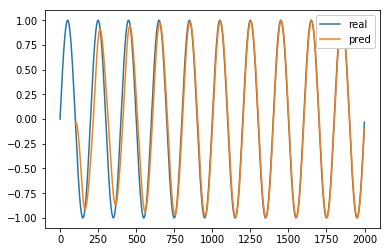

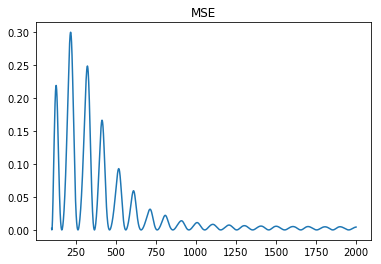

In [2]:
model = RNN()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=2e-4)
loss_func = nn.MSELoss()

# data collection
data = np.arange(2000)
data = data * np.pi / 100
data = np.sin(data)

h_state = None # initialization

pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, h_state)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800
epoch: 1000
epoch: 1200
epoch: 1400
epoch: 1600
epoch: 1800


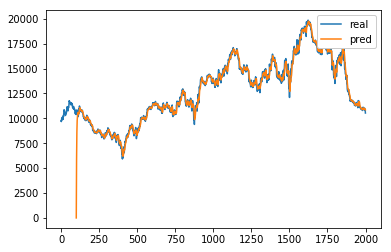

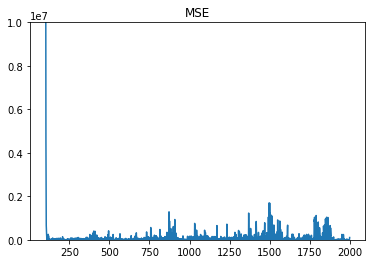

In [3]:
model = RNN()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=2e-4)
loss_func = nn.MSELoss()

# data collection
import csv
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))

h_state = None # initialize

length = 2000
pred = []
error = []
for step in range(length - 100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, h_state)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data[:length]), label='real')
plt.plot(range(100, length), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, length), error)
plt.ylim([0, 1e7])
plt.title('MSE')
plt.show()